In [1]:
import pandas as pd
import numpy as np
import pyhomogeneity as hg
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import skew, t
%config Completer.use_jedi = False #for auto complete code 

In [11]:
obs=pd.read_csv('../data/precp/chusis.csv',sep=';')

In [14]:
obs.head()

,Ano,dia,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Set,Oct,Nov,Dic
0,1980,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1980,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1980,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1980,4,0.0,0.0,0.0,7.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1980,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
def transform_precipitation_data(data):
    # Replace commas with dots for decimal conversion
    data = data.replace(',', '.', regex=True)

    # Convert the DataFrame to numeric, handling errors
    for column in data.columns[2:]:
        data[column] = pd.to_numeric(data[column], errors='coerce')

    # Rename columns to match the expected names
    data.rename(columns={'Ano': 'Año', 'dia': 'Día'}, inplace=True)

    # Melt the DataFrame
    df_melted = pd.melt(data, id_vars=['Año', 'Día'], value_vars=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Set', 'Oct', 'Nov', 'Dic'],
                        var_name='Mes', value_name='Precipitación')

    # Map Spanish month abbreviations to numbers
    month_mapping = {
        'Ene': 1, 'Feb': 2, 'Mar': 3, 'Abr': 4, 'May': 5, 'Jun': 6,
        'Jul': 7, 'Ago': 8, 'Set': 9, 'Oct': 10, 'Nov': 11, 'Dic': 12
    }
    df_melted['Mes'] = df_melted['Mes'].map(month_mapping)

    # Ensure the correct data types for the columns
    df_melted['Año'] = df_melted['Año'].astype(str)
    df_melted['Mes'] = df_melted['Mes'].astype(str)
    df_melted['Día'] = df_melted['Día'].astype(str)

    # Function to convert to datetime with error handling
    def convert_to_datetime(row):
        try:
            return pd.to_datetime(f"{row['Año']}-{row['Mes']}-{row['Día']}")
        except ValueError:
            return pd.NaT  # Return NaT for invalid dates

    # Apply the function to create 'Fecha' column
    df_melted['Fecha'] = df_melted.apply(convert_to_datetime, axis=1)

    # Select the desired columns
    df_final = df_melted[df_melted['Fecha'].notna()][['Fecha', 'Precipitación']] # Drop rows with NaT values

    return df_final

In [67]:
df = transform_precipitation_data(obs)

In [68]:
df.set_index('Fecha',inplace=True)
# Sort the DataFrame by the index (Fecha)
df.sort_index(inplace=True)

# Eliminate duplicate rows based on the index (Fecha)
df = df[~df.index.duplicated(keep='first')]

<Axes: xlabel='Fecha'>

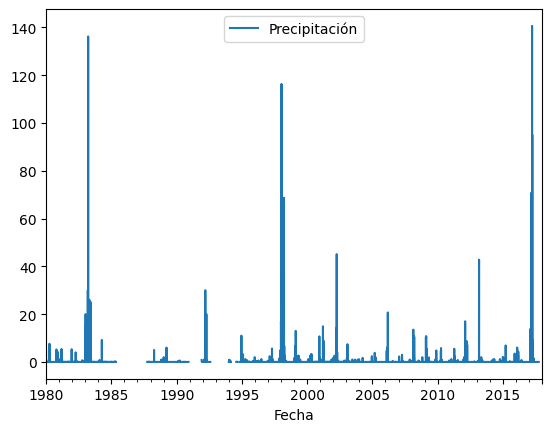

In [69]:
df.plot()

In [70]:
df.to_csv('review.csv',index=True)